In [1]:
!pip install einops

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from einops import rearrange
from sklearn.model_selection import train_test_split

## Import Data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## Observe Data

In [3]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)

X_train:  (60000, 28, 28)
X_test:  (10000, 28, 28)


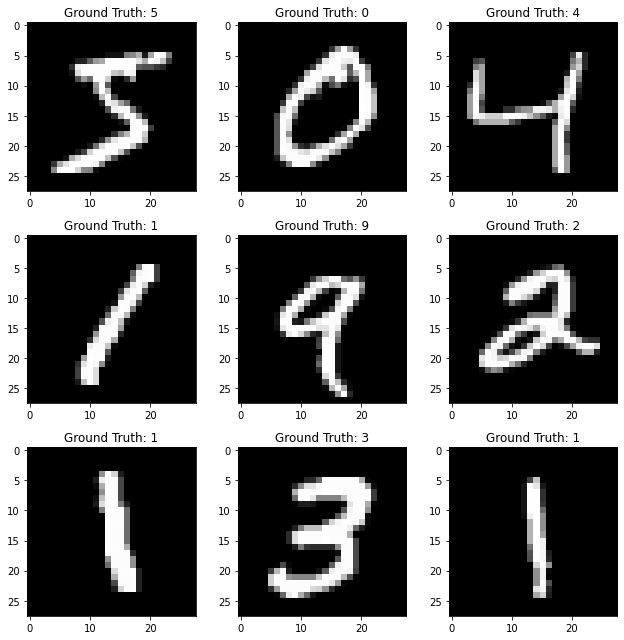

In [4]:
fig = plt.figure(figsize=(9, 9))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(X_train[i], cmap="gray", interpolation="none")
    target = y_train[i]
    plt.title("Ground Truth: {}".format(int(target)))

plt.show()

## Preprocessing

In [5]:
target_size = 10   # 0 ~ 9, 총 9개

### 주의: 흑백 데이터여도 channel 차원을 살려주어야 정상적으로 작동합니다
X_train = rearrange(X_train, "b h w -> b h w 1")
X_test = rearrange(X_test, "b h w -> b h w 1")

X_train = X_train.astype("float32") / (2 ** 8 - 1)   # 255로 scaling
X_test = X_test.astype("float32") / (2 ** 8 - 1)     # 255로 scaling

y_train = to_categorical(y_train, target_size)       # 타겟을 정수로 변환
y_test = to_categorical(y_test, target_size) 

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [7]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)
(48000, 10)
(12000, 10)
(10000, 10)


In [8]:
inputs = Input(shape=(28, 28, 1)) # 없어도 될거같은데..?

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding='same', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
#    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(64,  (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.8),
    
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
#    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5, gamma_initializer="uniform"),
    tf.keras.layers.ReLU(),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.8),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
 #   tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(2048, activation='relu'),
 #   tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0

In [9]:
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='min')
mc = ModelCheckpoint("{epoch:02d}-{val_loss:.4f}.ckpt", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
optim = Adam(learning_rate=0.01)
model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=256, epochs=15, validation_data=(X_val, y_val), verbose=1)

Epoch 1/15
188/188 [==============================] - 525s 3s/step - loss: 1.0189 - accuracy: 0.6924 - val_loss: 0.1654 - val_accuracy: 0.9517
Epoch 2/15
188/188 [==============================] - 531s 3s/step - loss: 0.4128 - accuracy: 0.8830 - val_loss: 0.1409 - val_accuracy: 0.9598
Epoch 3/15
188/188 [==============================] - 534s 3s/step - loss: 0.3864 - accuracy: 0.8932 - val_loss: 0.1018 - val_accuracy: 0.9722
Epoch 4/15
188/188 [==============================] - 529s 3s/step - loss: 0.3566 - accuracy: 0.9007 - val_loss: 0.1043 - val_accuracy: 0.9691
Epoch 5/15
188/188 [==============================] - 527s 3s/step - loss: 0.3628 - accuracy: 0.9010 - val_loss: 0.0942 - val_accuracy: 0.9727
Epoch 6/15
188/188 [==============================] - 525s 3s/step - loss: 0.3711 - accuracy: 0.8976 - val_loss: 0.0927 - val_accuracy: 0.9737
Epoch 7/15
188/188 [==============================] - 526s 3s/step - loss: 0.3609 - accuracy: 0.9011 - val_loss: 0.1038 - val_accuracy: 0.9707

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-7987eb7c1a18>", line 5, in <module>
    history = model.fit(X_train, y_train, batch_size=256, epochs=15, validation_data=(X_val, y_val), verbose=1)
  File "/usr/local/lib/python3.7/dist-packages/keras/engine/training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/eager/function.py", line 3040, in __call__
    filtered_flat_args, captured_inputs=graph_functio

KeyboardInterrupt: ignored

위에 있는 모델은

https://tobigs.gitbook.io/tobigs/deep-learning/undefined/advanced-neural-net-2

이 링크의 SOPCNN 모델을

https://paperswithcode.com/paper/stochastic-optimization-of-plain

SOPCNN 논문에 맞게 수정한 모델입니다!

총 수행시간 약 53분 / 최대 정확도 99.15%

## Sources
https://towardsdatascience.com/the-quest-of-higher-accuracy-for-cnn-models-42df5d731faf